# Regression with a feed forward neural network

Applied to predict temperature correlations at the atmosphere/ocean interface.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from mlcdc import SurfaceFeeder

In [2]:
ds = xr.open_zarr('../data/tcorr.predictors0.10lon.10lat.-1alev.-1olev.-1member.zarr')
ds['log10_atm_tprcp'] = np.log10(ds.atm_tprcp)
ds['atm_speed_srf'] = ds.atm_wind_speed.isel(alev=-1)
ds['ocn_speed_srf'] = ds.ocn_speed.isel(olev=0)
ds['ocn_u_srf'] = ds['ocn_u'].isel(olev=0)
ds['ocn_v_srf'] = ds['ocn_v'].isel(olev=0)
ds['log10_atm_tprcp'].attrs['long_name'] = 'derived log10 of tprcp'
ds['atm_speed_srf'].attrs['long_name'] = 'derived atmospheric surface wind speed'
ds['ocn_speed_srf'].attrs['long_name'] = 'derived ocean surface current speed'
ds['ocn_u_srf'].attrs['long_name'] = 'derived zonal ocean surface current speed'
ds['ocn_v_srf'].attrs['long_name'] = 'derived meridional ocean surface current speed'

ds['ocn_ubtav'] = ds['ocn_ubtav'].isel(olev=0)
ds['ocn_vbtav'] = ds['ocn_vbtav'].isel(olev=0)
ds['ocn_baro_srf'] = np.sqrt(ds.ocn_ubtav**2 + ds.ocn_vbtav**2)
ds['ocn_baro_srf'].attrs['long_name'] = 'derived barotropic ocean current speed'

ds['corr_atm_ocn'] = ds.corr_atm_ocn.isel(olev=0,alev=-1)

In [3]:
features_and_labels = [
    #'atm_cnvprcp_ave', # no idea what this is
    #'atm_ast',
    #'atm_T',
    'atm_q2m',
    'atm_qrain',
    'atm_t2m',
    #'atm_totprcp_ave',
    'atm_tprcp',
    #'log10_atm_tprcp',
    #'atm_u_srf',
    #'atm_v_srf',
    'atm_speed_srf',
    'ocn_MEKE',
    #'ocn_MEKE_Kh', # probably need MEKE, if anything, not the diffusivity ...
    'ocn_MLD',
    #'ocn_MLD_MLE_filtered', # just use instantaneous, not time filtered version...
    #'ocn_ave_ssh', # use instantaneous version
    'ocn_sfc',
    'ocn_sst',
    #'ocn_u_srf',
    #'ocn_v_srf',
    'ocn_speed_srf',
    'ocn_baro_srf',
    #'ocn_Temp',
    'corr_atm_ocn'
]

In [4]:
for key in features_and_labels:
    if 'long_name' in ds[key].attrs:
        print(f"{key:<24s}: {ds[key].long_name}")

atm_q2m                 : q2m
atm_qrain               : qrain
atm_t2m                 : t2m
atm_tprcp               : tprcp
atm_speed_srf           : derived atmospheric surface wind speed
ocn_MEKE                : Mesoscale Eddy Kinetic Energy
ocn_MLD                 : Instantaneous active mixing layer depth
ocn_sfc                 : Free surface Height
ocn_sst                 : Sea surface temperature (derived)
ocn_speed_srf           : derived ocean surface current speed
ocn_baro_srf            : derived barotropic ocean current speed


### Select correlation only at the surface

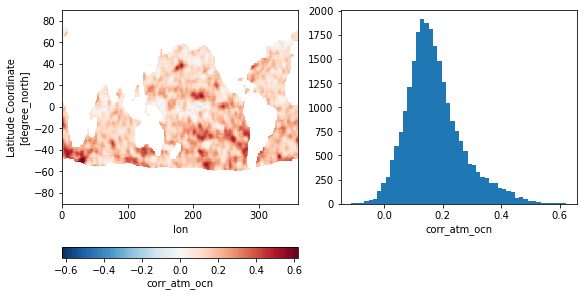

In [5]:
fig, axs = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)
ds.corr_atm_ocn.plot(ax=axs[0],cbar_kwargs={'orientation':'horizontal'})
ds.corr_atm_ocn.plot.hist(ax=axs[1], bins=50);

In [6]:
df = ds[features_and_labels].to_dataframe()

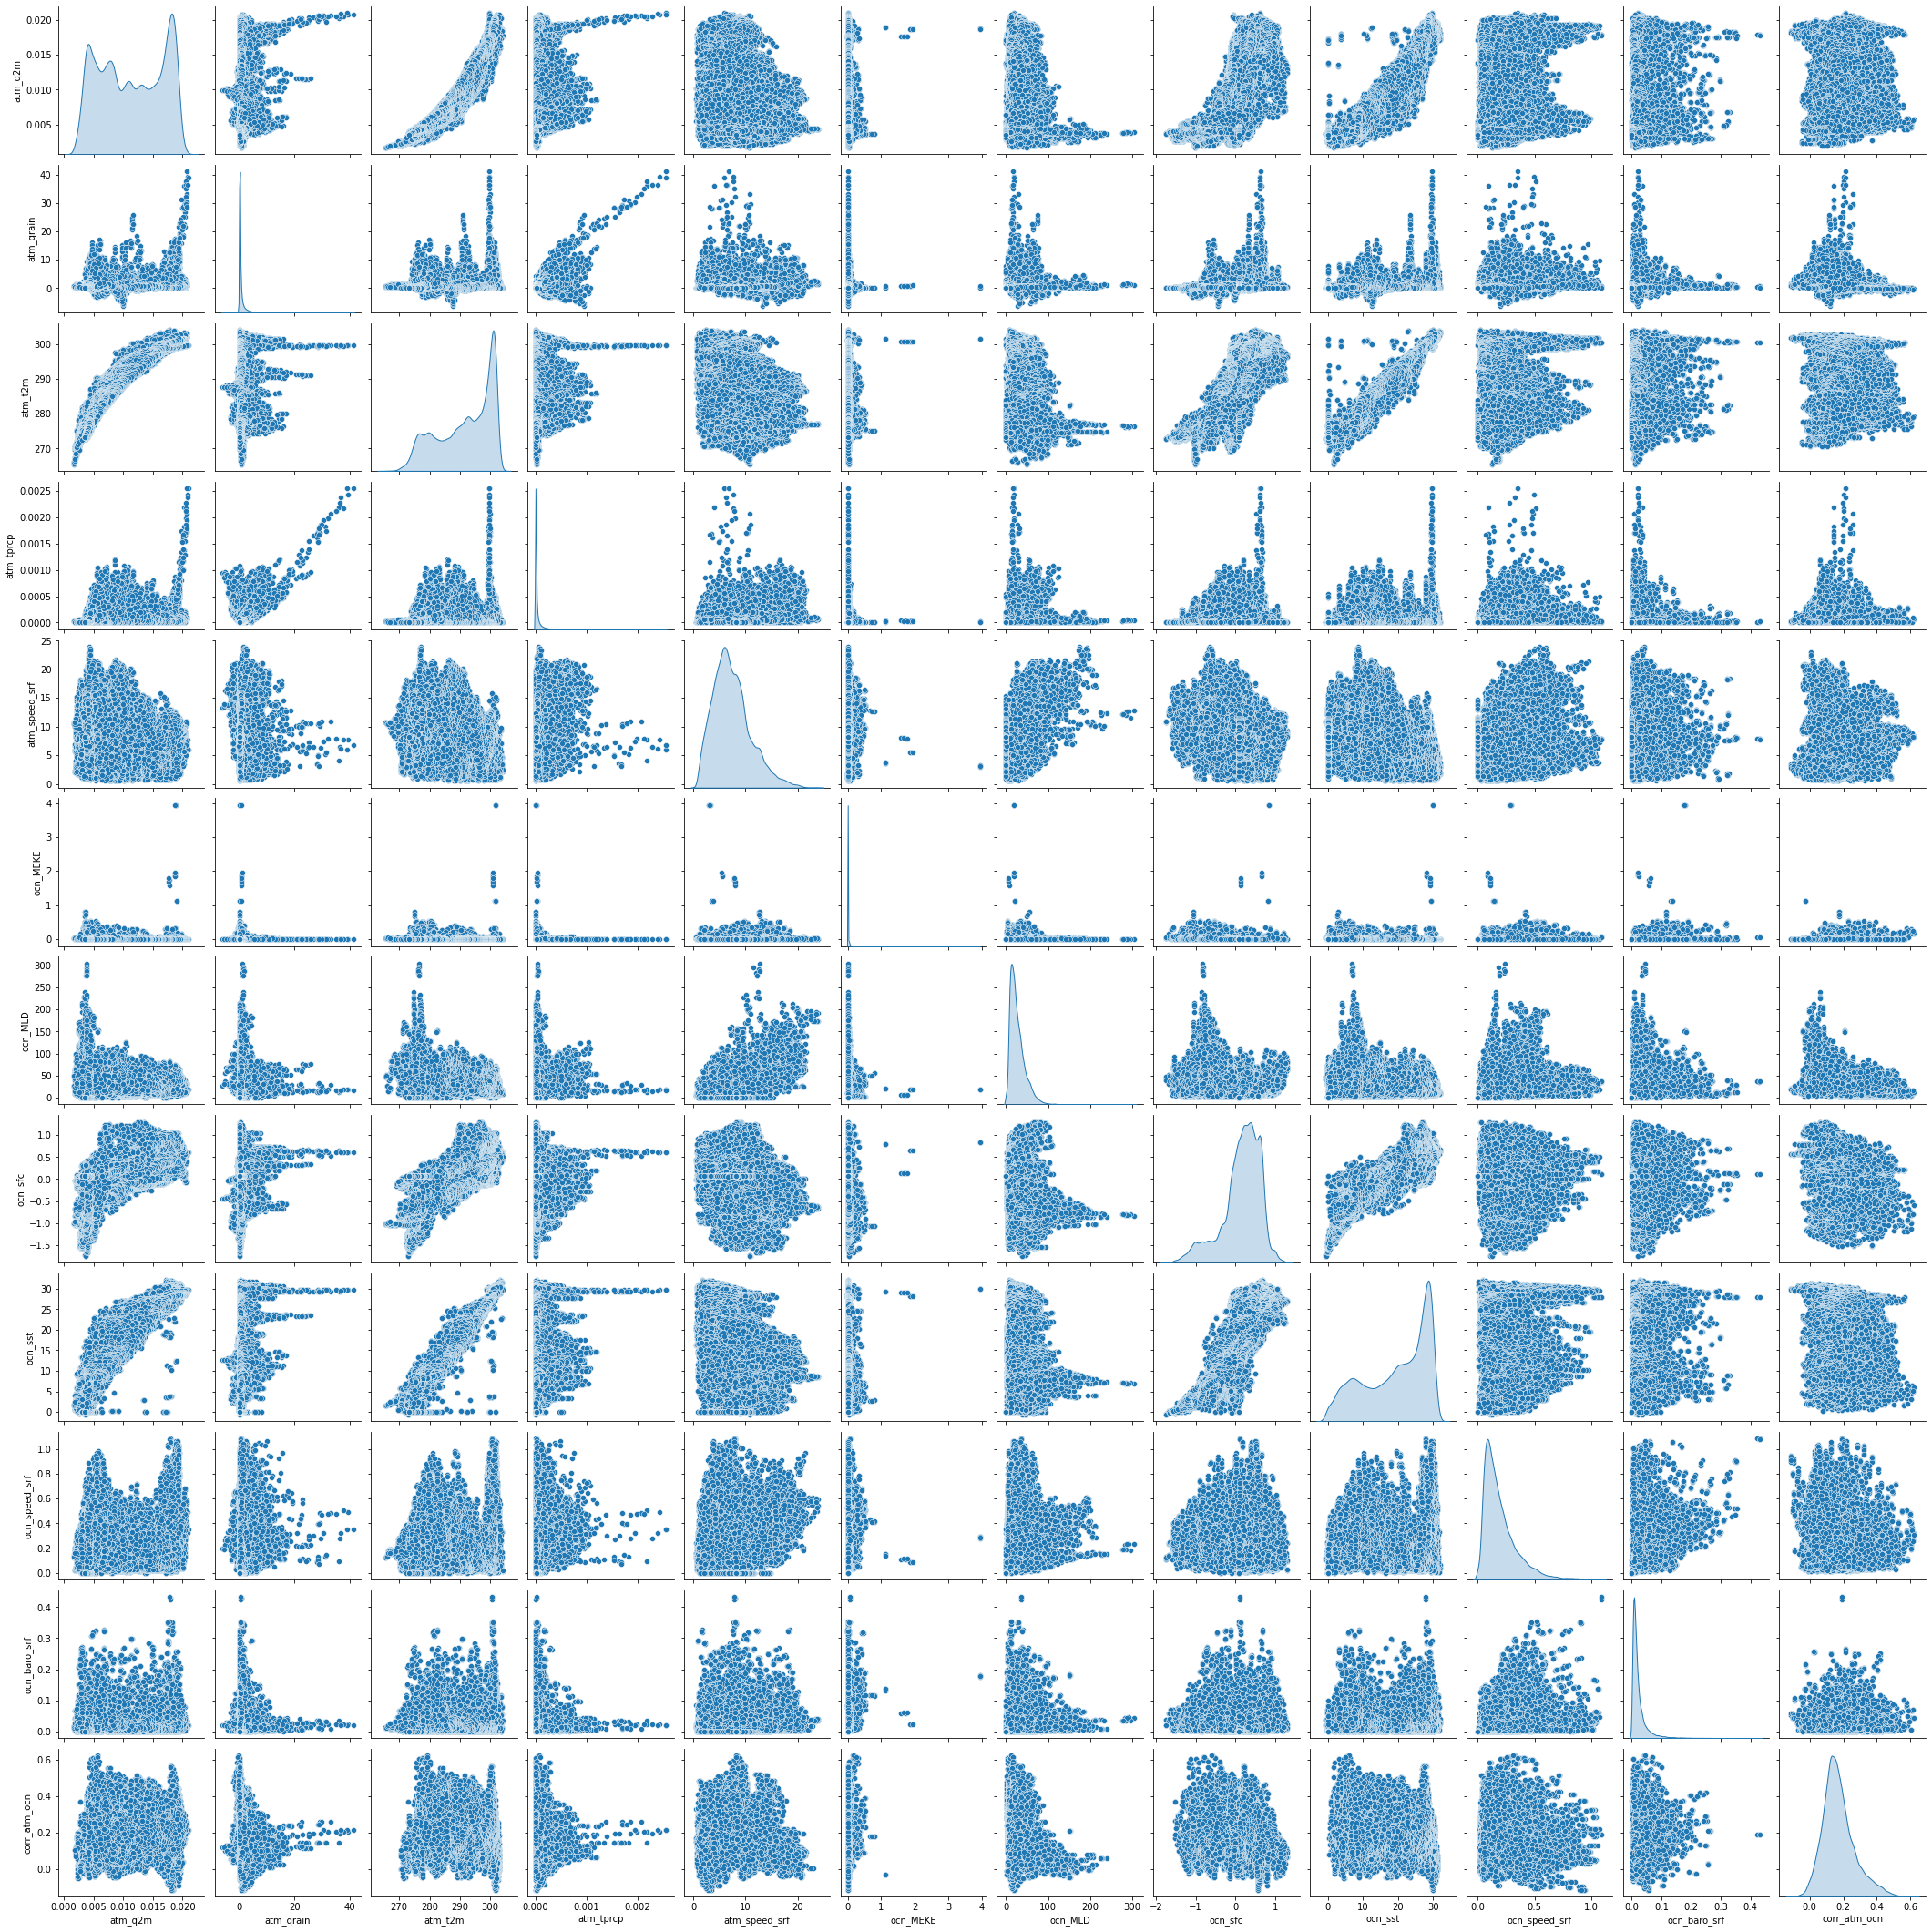

In [7]:
sns.pairplot(df, diag_kind='kde')

## Prepare the data

In [11]:
features = features_and_labels.copy()
features.remove('corr_atm_ocn')

In [12]:
features

['atm_q2m',
 'atm_qrain',
 'atm_t2m',
 'atm_tprcp',
 'atm_speed_srf',
 'ocn_MEKE',
 'ocn_MLD',
 'ocn_sfc',
 'ocn_sst',
 'ocn_speed_srf',
 'ocn_baro_srf']

In [13]:
kf = SurfaceFeeder(feature_names=features,
                 label_name='corr_atm_ocn',
                 mask_name='ocn_mask',
                 training_fraction=0.8,
                 load_into_memory=True)

In [14]:
kf

KerasFeeder:

    Features:
        atm_q2m, atm_qrain, atm_t2m, atm_tprcp, atm_speed_srf, ocn_MEKE, ocn_MLD, ocn_sfc, ocn_sst, ocn_speed_srf, ocn_baro_srf
        status = unset

    Labels:
        corr_atm_ocn
        status = unset

    Inputs:
        None
        status = unset

 --- 
    Training Fraction       : 0.8
    Normalize Data          : True
    Load into Memory        : True

In [15]:
kf(ds)

In [16]:
kf

KerasFeeder:

    Features:
        atm_q2m, atm_qrain, atm_t2m, atm_tprcp, atm_speed_srf, ocn_MEKE, ocn_MLD, ocn_sfc, ocn_sst, ocn_speed_srf, ocn_baro_srf
        status = set

    Labels:
        corr_atm_ocn
        status = set

    Inputs:
        [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'atm_q2m')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'atm_qrain')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'atm_t2m')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'atm_tprcp')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'atm_speed_srf')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ocn_MEKE')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ocn_MLD')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ocn_sfc')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ocn_sst')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by laye

## Create the model

Input layers are created in `KerasFeeder`, for simple linear regression, just merge the inputs and feed to output.

In [22]:
def make_model(xkf, regularizer=keras.regularizers.L2, regularization=1e-6,
               hidden_units=[16],
               hidden_activation=None,
               learning_rate=1e-4,
              ):
    
    if not isinstance(hidden_activation, (list, tuple, np.ndarray)):
        hidden_activation = [hidden_activation] * len(hidden_units)
    
    hidden = keras.layers.concatenate(xkf.inputs)
    
    for units, activation in zip(hidden_units, hidden_activation):
        hidden = keras.layers.Dense(
            units=units,
            activation=activation,
            kernel_regularizer=regularizer(regularization),
            bias_regularizer=regularizer(regularization),
        )(hidden)
    
    output = keras.layers.Dense(
        activation='tanh',
        units=1, name='ao_corr'
    )(hidden)
    
    # stick it together
    model = keras.Model(
        inputs=xkf.inputs,
        outputs=[output]
    )
    
    # compile
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=learning_rate,
        ),
        loss=keras.losses.Huber(delta=1),
        #loss=keras.losses.MeanSquaredError(),
    )
    return model

In [36]:
#units = [128]*3
units = [64]*6
activation = 'swish' #['tanh', 'tanh']

model = make_model(kf,
                   regularizer=keras.regularizers.L1,
                   regularization=1e-7,
                   hidden_units=units,
                   hidden_activation=activation,
                   learning_rate=1e-3,
                )

In [37]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 atm_q2m (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 atm_qrain (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 atm_t2m (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 atm_tprcp (InputLayer)         [(None, 1)]          0           []                               
                                                                                            

In [38]:
%%time
history = model.fit(
    x=kf.x_training, 
    y=kf.labels['training'].values,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    verbose=False,
)

CPU times: user 2min 39s, sys: 16.1 s, total: 2min 55s
Wall time: 1min 45s


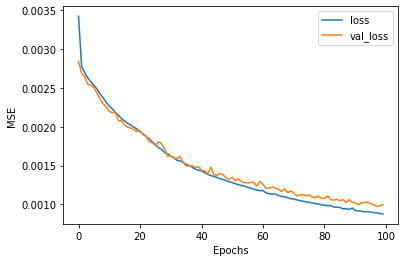

In [39]:
fig,ax=plt.subplots()
for key in ['loss','val_loss']:
    ax.plot(history.history[key],label=key)
ax.set(xlabel='Epochs', ylabel='MSE')
ax.legend()

In [40]:
prediction = model.predict(kf.x_testing)
xpred = xr.DataArray(prediction.squeeze(),coords=kf.labels['testing'].coords, dims=kf.labels['testing'].dims)

619/619 [==============================] - 1s 958us/step


[Text(0.5, 0, 'Truth'), Text(0, 0.5, 'Prediction')]

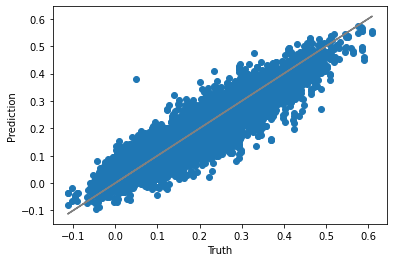

In [41]:
fig, ax = plt.subplots()
ax.scatter(kf.labels['testing'],
           xpred,
          )
ax.plot(kf.labels['testing'],
        kf.labels['testing'],
        color='gray')
ax.set(xlabel='Truth',ylabel='Prediction')

### Notes

- Setting regularization to ~$10^{-7} - 10^{-8}$ is what finally got the prediction to be at least span the 1:1 line 
- When regularization is too high, predictions well be a flat line (near zero)
- Low learning rate ~$10^{-3}-10^{-4}$ seems to be good

### Other things to try

- Other optimizers, e.g. with adaptive learning rate. See [this stackoverflow post](https://stackoverflow.com/questions/33919948/how-to-set-adaptive-learning-rate-for-gradientdescentoptimizer) and
[these experiments](https://github.com/vsmolyakov/experiments_with_python/blob/master/chp03/tensorflow_optimizers.ipynb)
- Potentially useful: http://uc-r.github.io/ann_regression
- How many layers is actually necessary? How wide is necessary? Activation functions?
- Residual Neural Network
- Can we add uncertainty?